In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/datasets/COVID-19_Radiography_Dataset.zip

In [ ]:
!ls COVID-19_Radiography_Dataset

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [ ]:
import tensorflow as tf 
import os 

def prepare_datasets(data_dir, train_pct=0.6, val_pct=0.2, test_pct=0.2, batch_size=64, img_size=(299,299)):
  
  if train_pct + val_pct + test_pct != 1:
    assert False

  dataset = tf.keras.utils.image_dataset_from_directory(data_dir, color_mode='rgb', batch_size=batch_size, image_size=img_size, shuffle=True, seed=None, interpolation='bilinear')
  classes = dataset.class_names
  total_files = 0
  for item in os.listdir(data_dir):
    path = os.path.join(data_dir, item)
    if os.path.isdir(path):
      total_files += len(os.listdir(path))

  dataset_size = total_files
  batches = int(dataset_size / batch_size)
  train_size = int(train_pct * batches)
  val_size = int(val_pct * batches)

  dev_ds = dataset.take(train_size + val_size)
  train_ds = dataset.take(train_size)    
  val_ds = dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)

  return dev_ds, train_ds, val_ds, test_ds, classes

In [ ]:
dev_ds, train_ds, val_ds, test_ds, classes = prepare_datasets(data_dir="COVID-19_Radiography_Dataset")

Found 21165 files belonging to 4 classes.


In [ ]:
classes

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

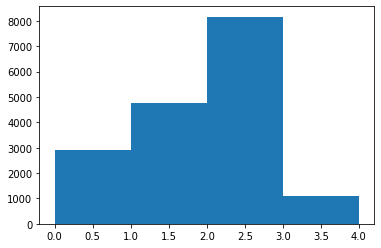

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = np.concatenate([y for x, y in dev_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

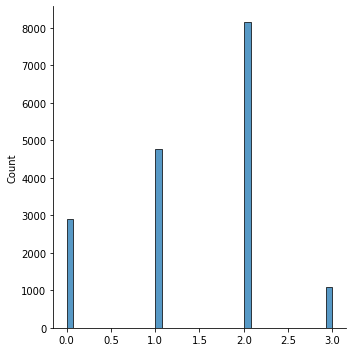

In [ ]:
import seaborn as sns
sns.displot(y)
plt.show()

In [ ]:
def cnn1(num_classes):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),                                       
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

  return model

In [ ]:
model = cnn1(4)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99),
                metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
history = model.fit(train_ds,validation_data=val_ds, epochs=20, batch_size=64, callbacks=[early_stopping])

Epoch 1/20
198/198 [==============================] - 72s 313ms/step - loss: 1.1351 - accuracy: 0.5871 - val_loss: 0.8062 - val_accuracy: 0.6634
Epoch 2/20
198/198 [==============================] - 62s 311ms/step - loss: 0.6844 - accuracy: 0.7268 - val_loss: 0.7411 - val_accuracy: 0.6870
Epoch 3/20
198/198 [==============================] - 60s 301ms/step - loss: 0.5581 - accuracy: 0.7827 - val_loss: 0.5922 - val_accuracy: 0.7723
Epoch 4/20
198/198 [==============================] - 62s 307ms/step - loss: 0.4879 - accuracy: 0.8117 - val_loss: 0.5306 - val_accuracy: 0.7990
Epoch 5/20
198/198 [==============================] - 60s 301ms/step - loss: 0.4304 - accuracy: 0.8410 - val_loss: 0.5558 - val_accuracy: 0.7926
Epoch 6/20
198/198 [==============================] - 62s 310ms/step - loss: 0.3765 - accuracy: 0.8621 - val_loss: 0.5613 - val_accuracy: 0.7929
Epoch 7/20
198/198 [==============================] - 60s 300ms/step - loss: 0.3196 - accuracy: 0.8858 - val_loss: 0.5235 - val_ac

In [ ]:
import numpy as np

def confusion_matrix(model, test_ds):
  y_test = []
  y_pred = []
  for x_1, y_1 in test_ds:
    y_pred_1 = model.predict(x_1)
    y_test.append(y_1)
    y_pred.append(y_pred_1)
  y_true = np.concatenate(y_test)
  y_p = np.concatenate(y_pred)
  y_hat = tf.argmax(y_p, axis=1)
  cm = tf.math.confusion_matrix(y_true, y_hat)
  return cm, y_hat

In [ ]:
cm, y_hat = confusion_matrix(model, test_ds)

2/2 [==============================] - 0s 123ms/step


In [ ]:
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 530,  105,   85,    4],
       [  31, 1044,  181,    3],
       [  55,  288, 1649,   32],
       [   4,   13,    6,  239]], dtype=int32)>

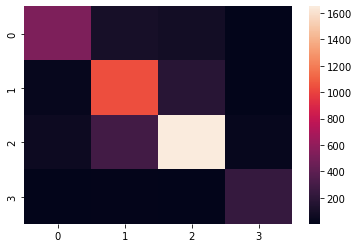

In [ ]:
sns.heatmap(cm)

In [ ]:
def cnn2(num_classes):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),                                       
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=4),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

  return model

In [ ]:
model = cnn2(4)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99),
                metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,validation_data=val_ds, epochs=20, batch_size=64, callbacks=[early_stopping])

Epoch 1/20
198/198 [==============================] - 96s 458ms/step - loss: 1.0903 - accuracy: 0.5335 - val_loss: 0.8573 - val_accuracy: 0.6560
Epoch 2/20
198/198 [==============================] - 92s 461ms/step - loss: 0.8138 - accuracy: 0.6681 - val_loss: 0.7507 - val_accuracy: 0.7041
Epoch 3/20
198/198 [==============================] - 91s 455ms/step - loss: 0.6967 - accuracy: 0.7211 - val_loss: 0.6729 - val_accuracy: 0.7308
Epoch 4/20
198/198 [==============================] - 91s 456ms/step - loss: 0.6178 - accuracy: 0.7542 - val_loss: 0.5995 - val_accuracy: 0.7625
Epoch 5/20
198/198 [==============================] - 91s 454ms/step - loss: 0.5644 - accuracy: 0.7783 - val_loss: 0.5675 - val_accuracy: 0.7789
Epoch 6/20
198/198 [==============================] - 91s 454ms/step - loss: 0.5177 - accuracy: 0.7973 - val_loss: 0.5015 - val_accuracy: 0.8018
Epoch 7/20
198/198 [==============================] - 91s 455ms/step - loss: 0.4725 - accuracy: 0.8196 - val_loss: 0.4680 - val_ac

In [ ]:
cm, y_hat = confusion_matrix(model, test_ds)

2/2 [==============================] - 1s 514ms/step


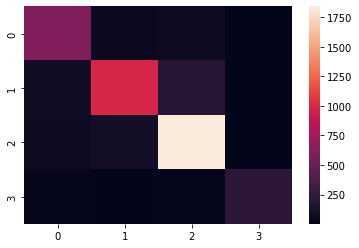

In [ ]:
sns.heatmap(cm)

In [ ]:
inputs = tf.keras.layers.Input(shape=(299, 299, 3))

preproc = tf.keras.models.Sequential([
         tf.keras.layers.experimental.preprocessing.Resizing(224,224)
])

x = preproc(inputs)

effnet = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet', input_tensor=x, include_top=False)
effnet.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(effnet.output)

outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99),
                metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,validation_data=val_ds, epochs=5, batch_size=32, callbacks=[early_stopping])

Epoch 1/5
198/198 [==============================] - 70s 320ms/step - loss: 0.6518 - accuracy: 0.7502 - val_loss: 0.4825 - val_accuracy: 0.8205
Epoch 2/5
198/198 [==============================] - 61s 306ms/step - loss: 0.4389 - accuracy: 0.8426 - val_loss: 0.4099 - val_accuracy: 0.8494
Epoch 3/5
198/198 [==============================] - 62s 312ms/step - loss: 0.3899 - accuracy: 0.8554 - val_loss: 0.3905 - val_accuracy: 0.8501
Epoch 4/5
198/198 [==============================] - 62s 307ms/step - loss: 0.3567 - accuracy: 0.8733 - val_loss: 0.3532 - val_accuracy: 0.8722
Epoch 5/5
198/198 [==============================] - 63s 314ms/step - loss: 0.3351 - accuracy: 0.8805 - val_loss: 0.3433 - val_accuracy: 0.8719


In [ ]:
cm, y_hat = confusion_matrix(model, test_ds)

2/2 [==============================] - 2s 471ms/step


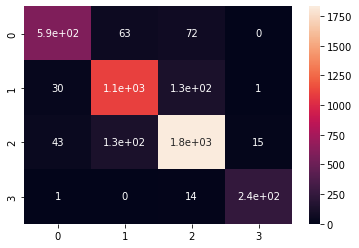

In [ ]:
sns.heatmap(cm, annot=True)